# This is a google colab implementation of Clothes-Extraction-Module.

# SETUP (SCHP)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://github.com/GoGoDuck912/Self-Correction-Human-Parsing

In [2]:
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing
!mkdir checkpoints


fatal: destination path 'Self-Correction-Human-Parsing' already exists and is not an empty directory.
/content/Self-Correction-Human-Parsing
mkdir: cannot create directory ‘checkpoints’: File exists


Select dataset below

In [4]:
dataset = 'atr'         #select from ['lip', 'atr', 'pascal']

In [5]:
import gdown

if dataset == 'lip':
    url = 'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH'
elif dataset == 'atr':
    url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
elif dataset == 'pascal':
    url = 'https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE'

output = 'checkpoints/final.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP
To: /content/Self-Correction-Human-Parsing/checkpoints/final.pth
100%|██████████| 267M/267M [00:00<00:00, 291MB/s]


'checkpoints/final.pth'

# RUN SCHP

Create a folder on your drive to store the input images and segmentation results.

In [6]:
%cd /content/drive/MyDrive

#input folder
%mkdir input
#output folder
%mkdir output

/content/drive/MyDrive


Please select images which you want to upload

In [7]:
#Please move to the folder for input images
%cd /content/drive/MyDrive/input

from google.colab import files
uploaded = files.upload()
%cd /content/Self-Correction-Human-Parsing

/content/drive/MyDrive/input


Saving test_image.jpg to test_image.jpg
/content/Self-Correction-Human-Parsing


SCHP is applied to the images in the folder specified by input-dir, and the segmentation results are output to the folder specified by output-dir.


In [8]:
!python3 simple_extractor.py --dataset 'atr' --model-restore 'checkpoints/final.pth' --input-dir '/content/drive/MyDrive/input' --output-dir '/content/drive/MyDrive/output'

Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 1/1 [00:01<00:00,  1.58s/it]


# RUN Clothes-Extraction-Module

original image


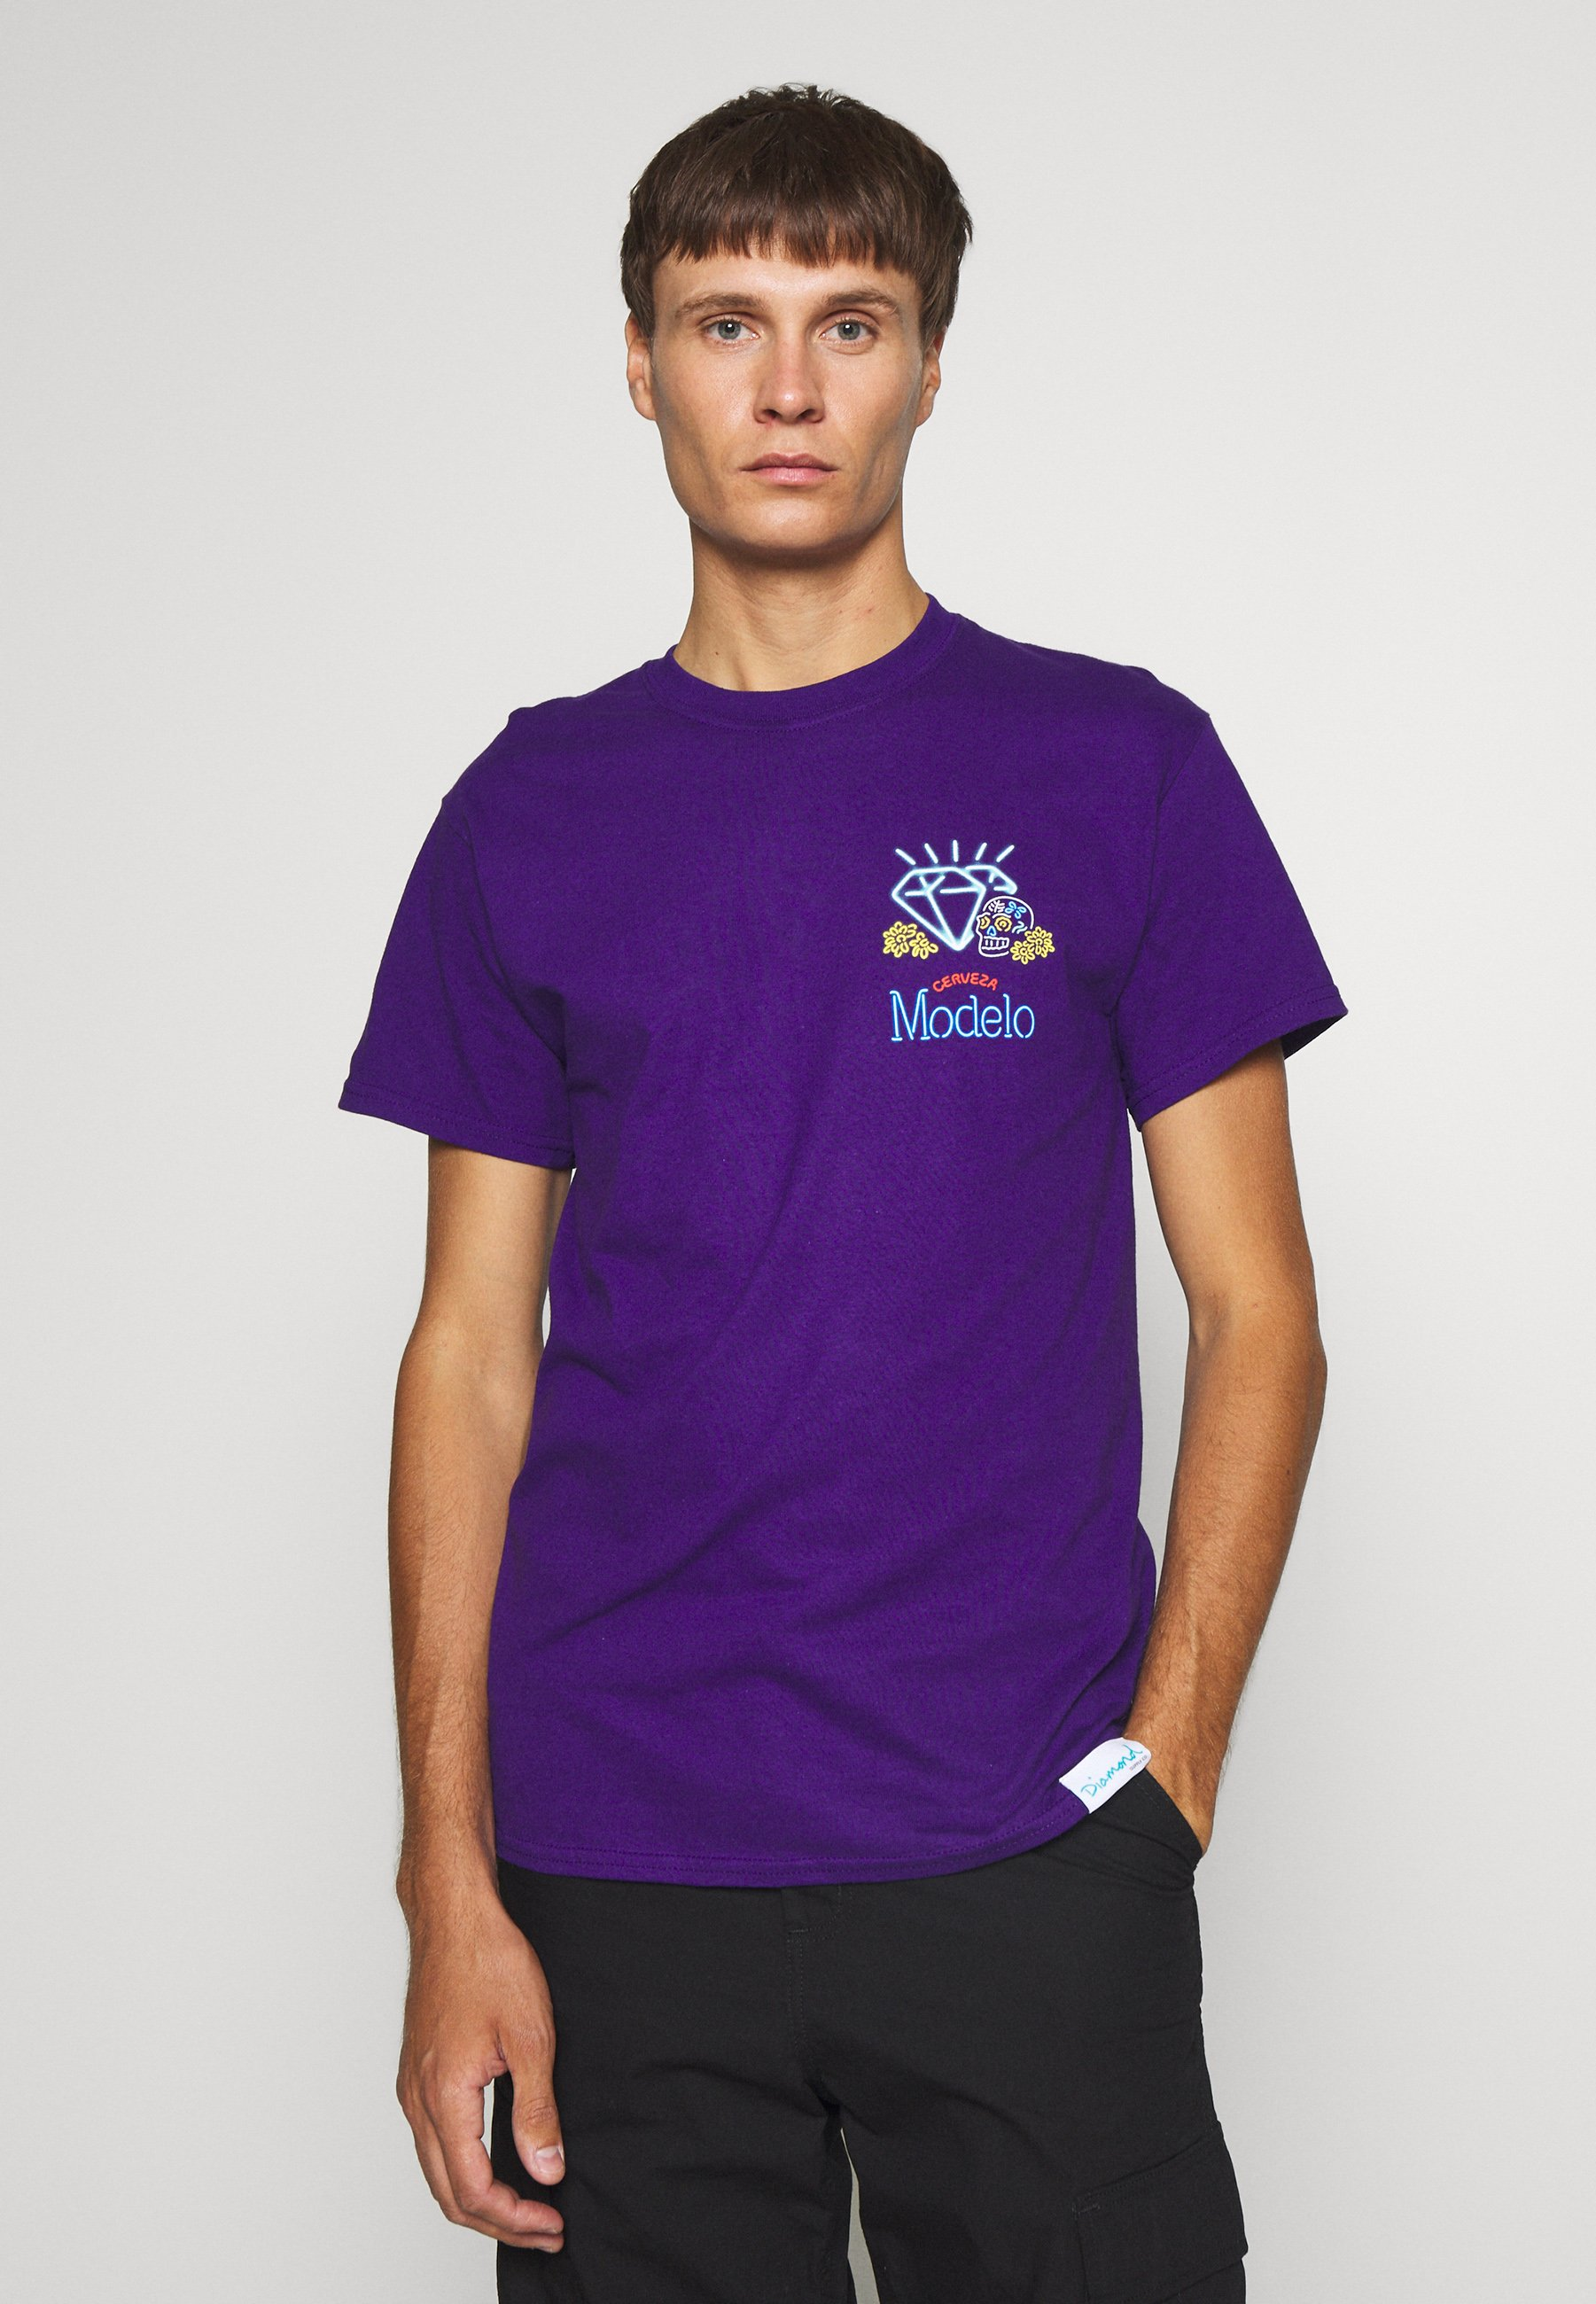

segmentation results


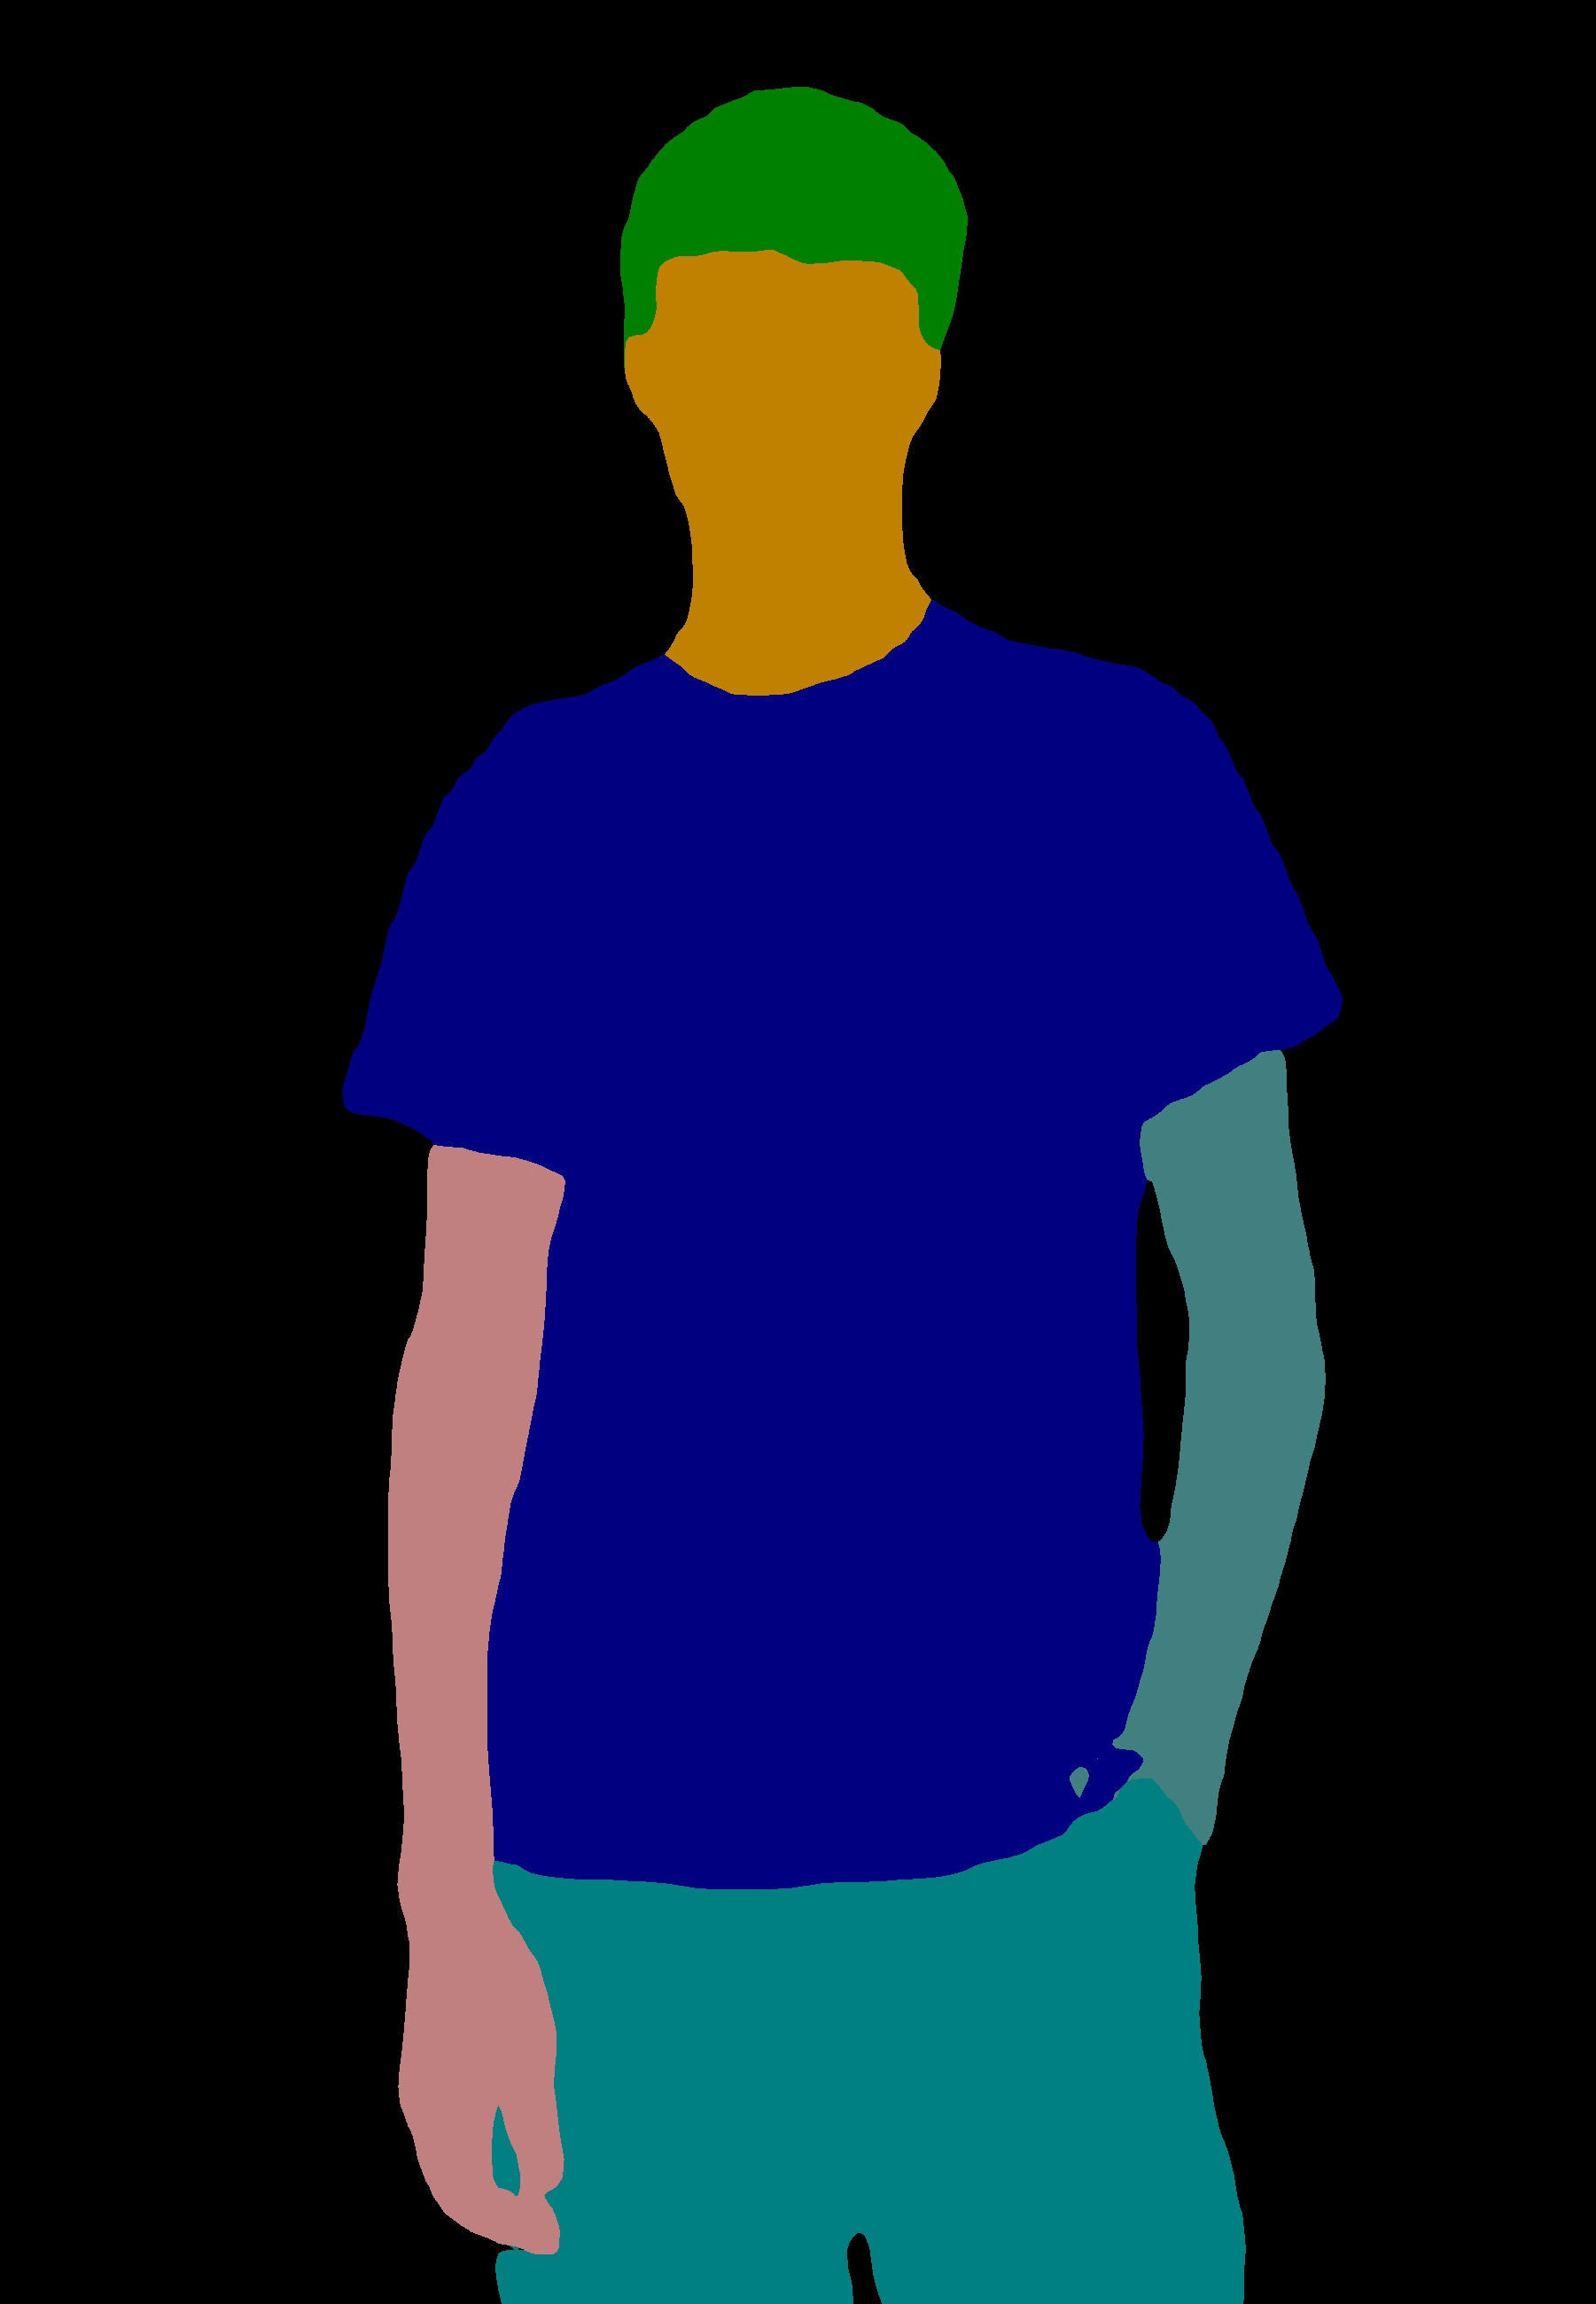

mask image


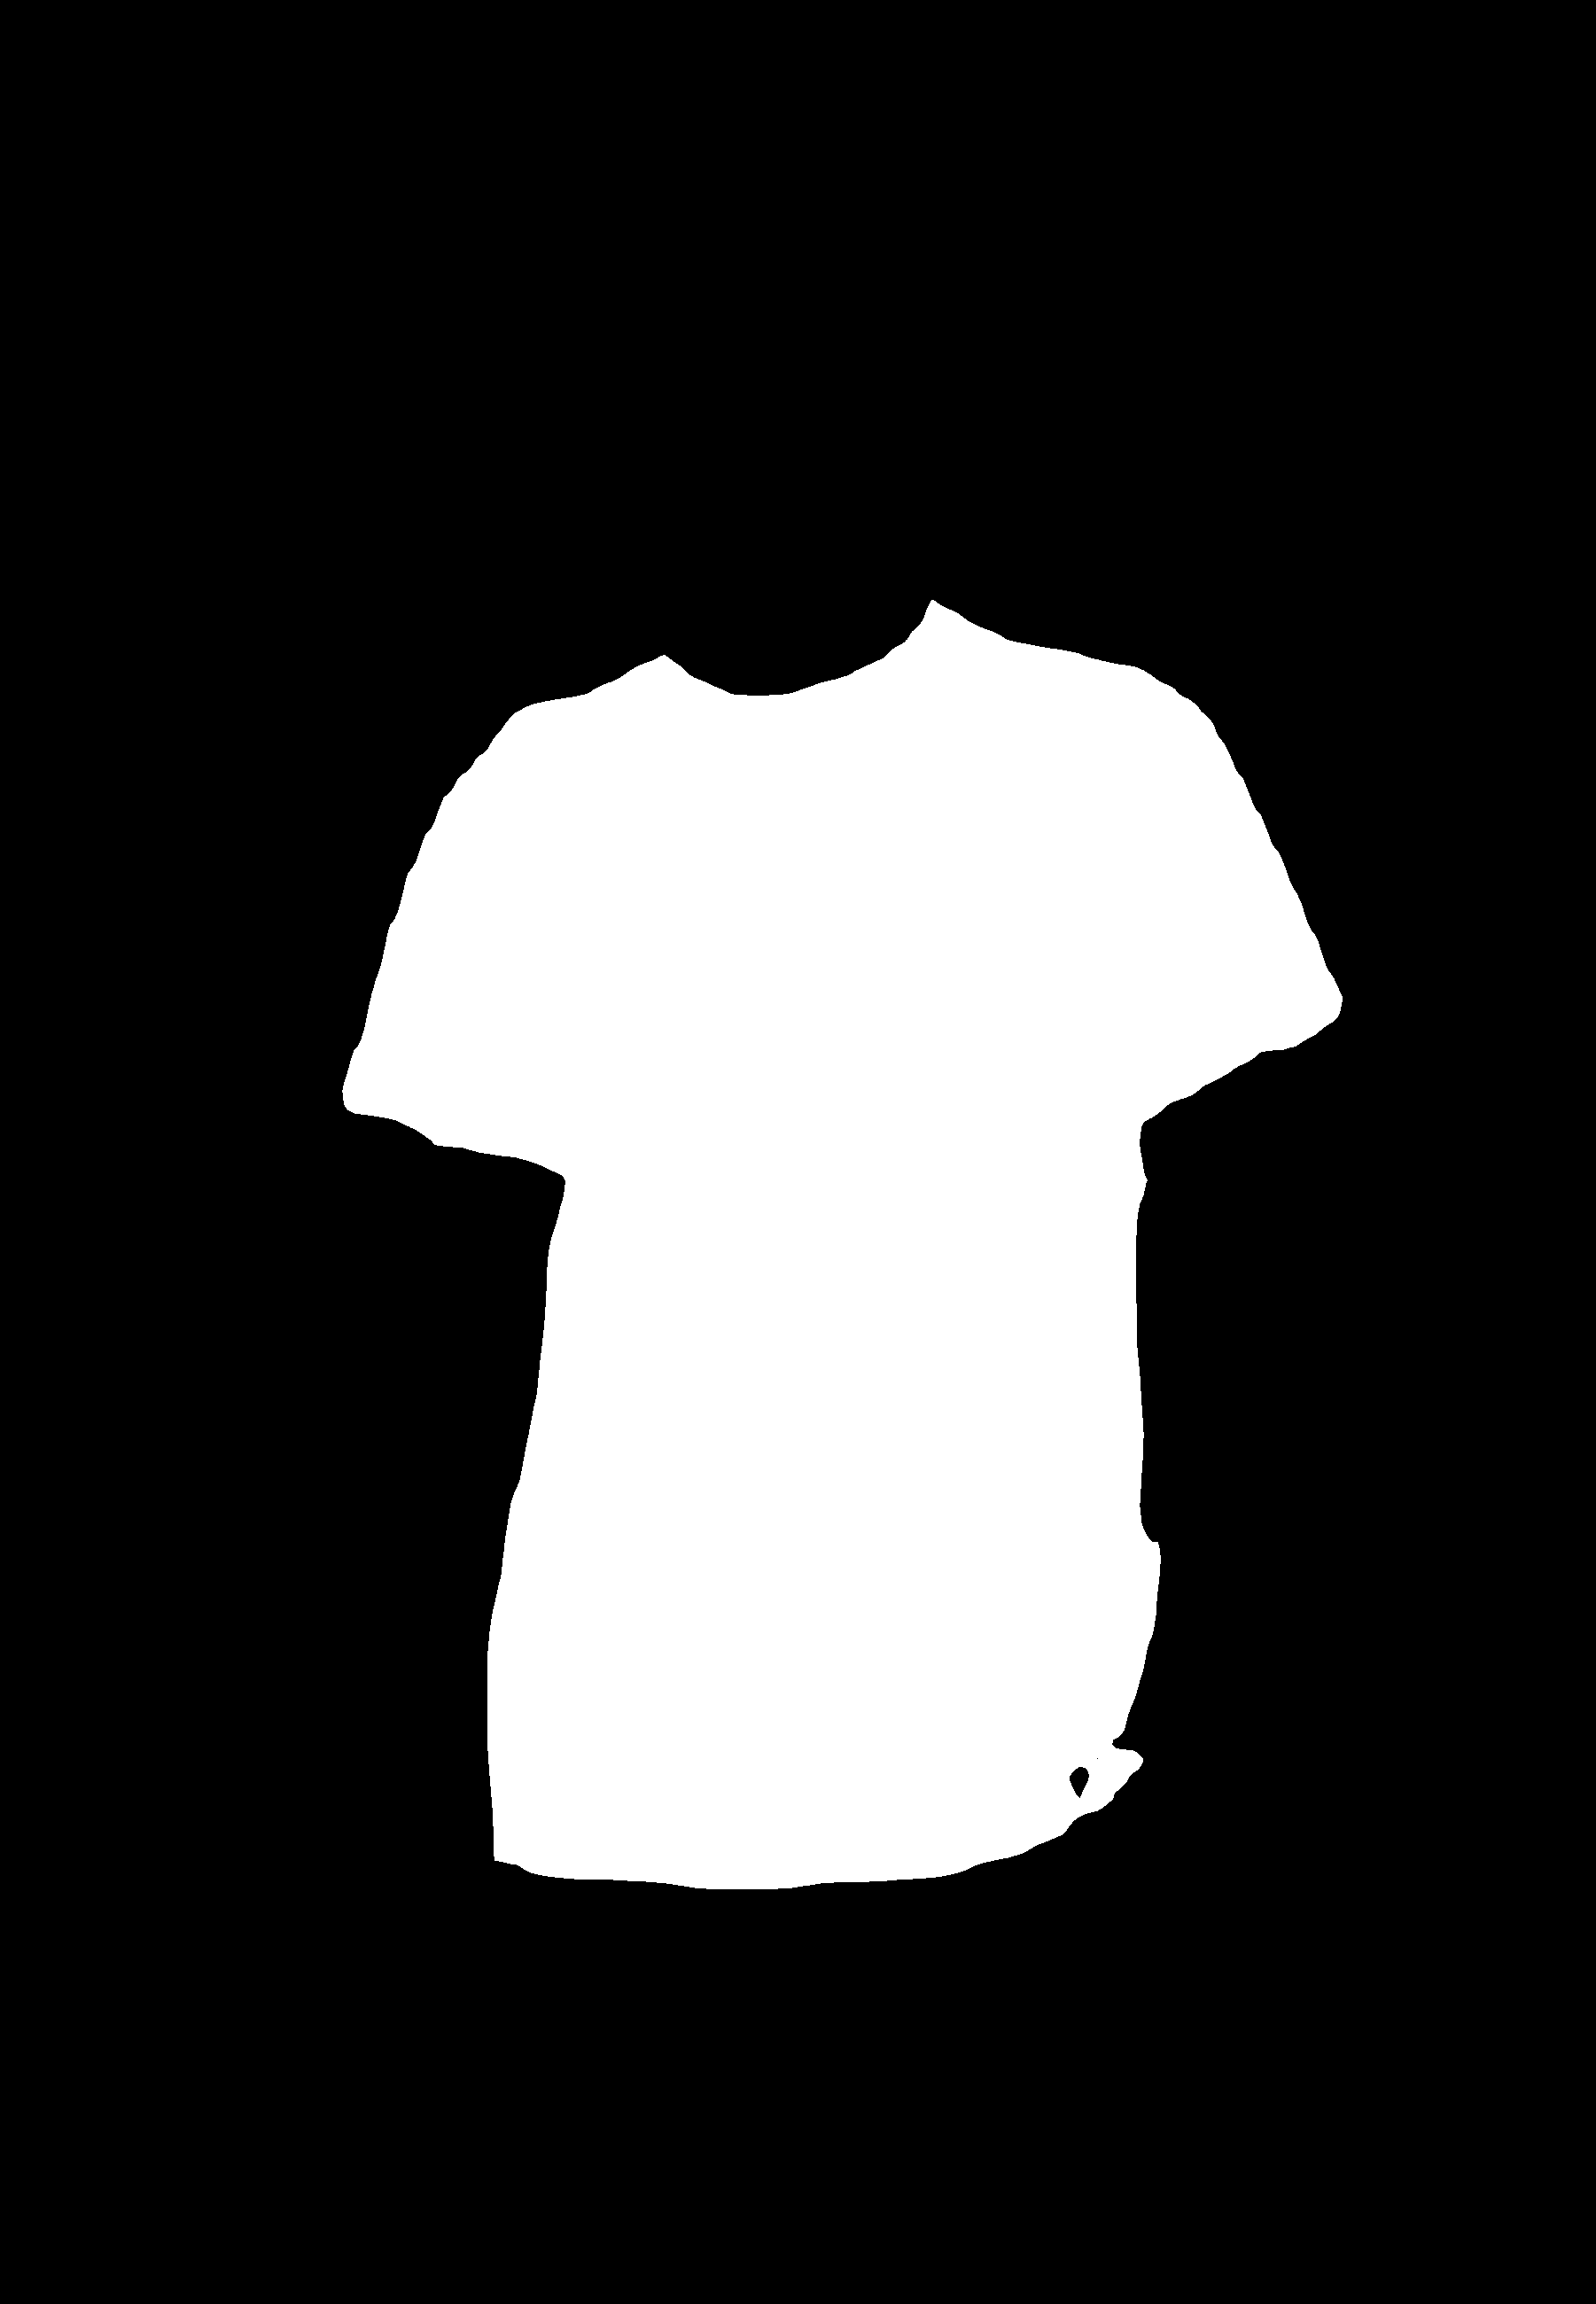

composite result


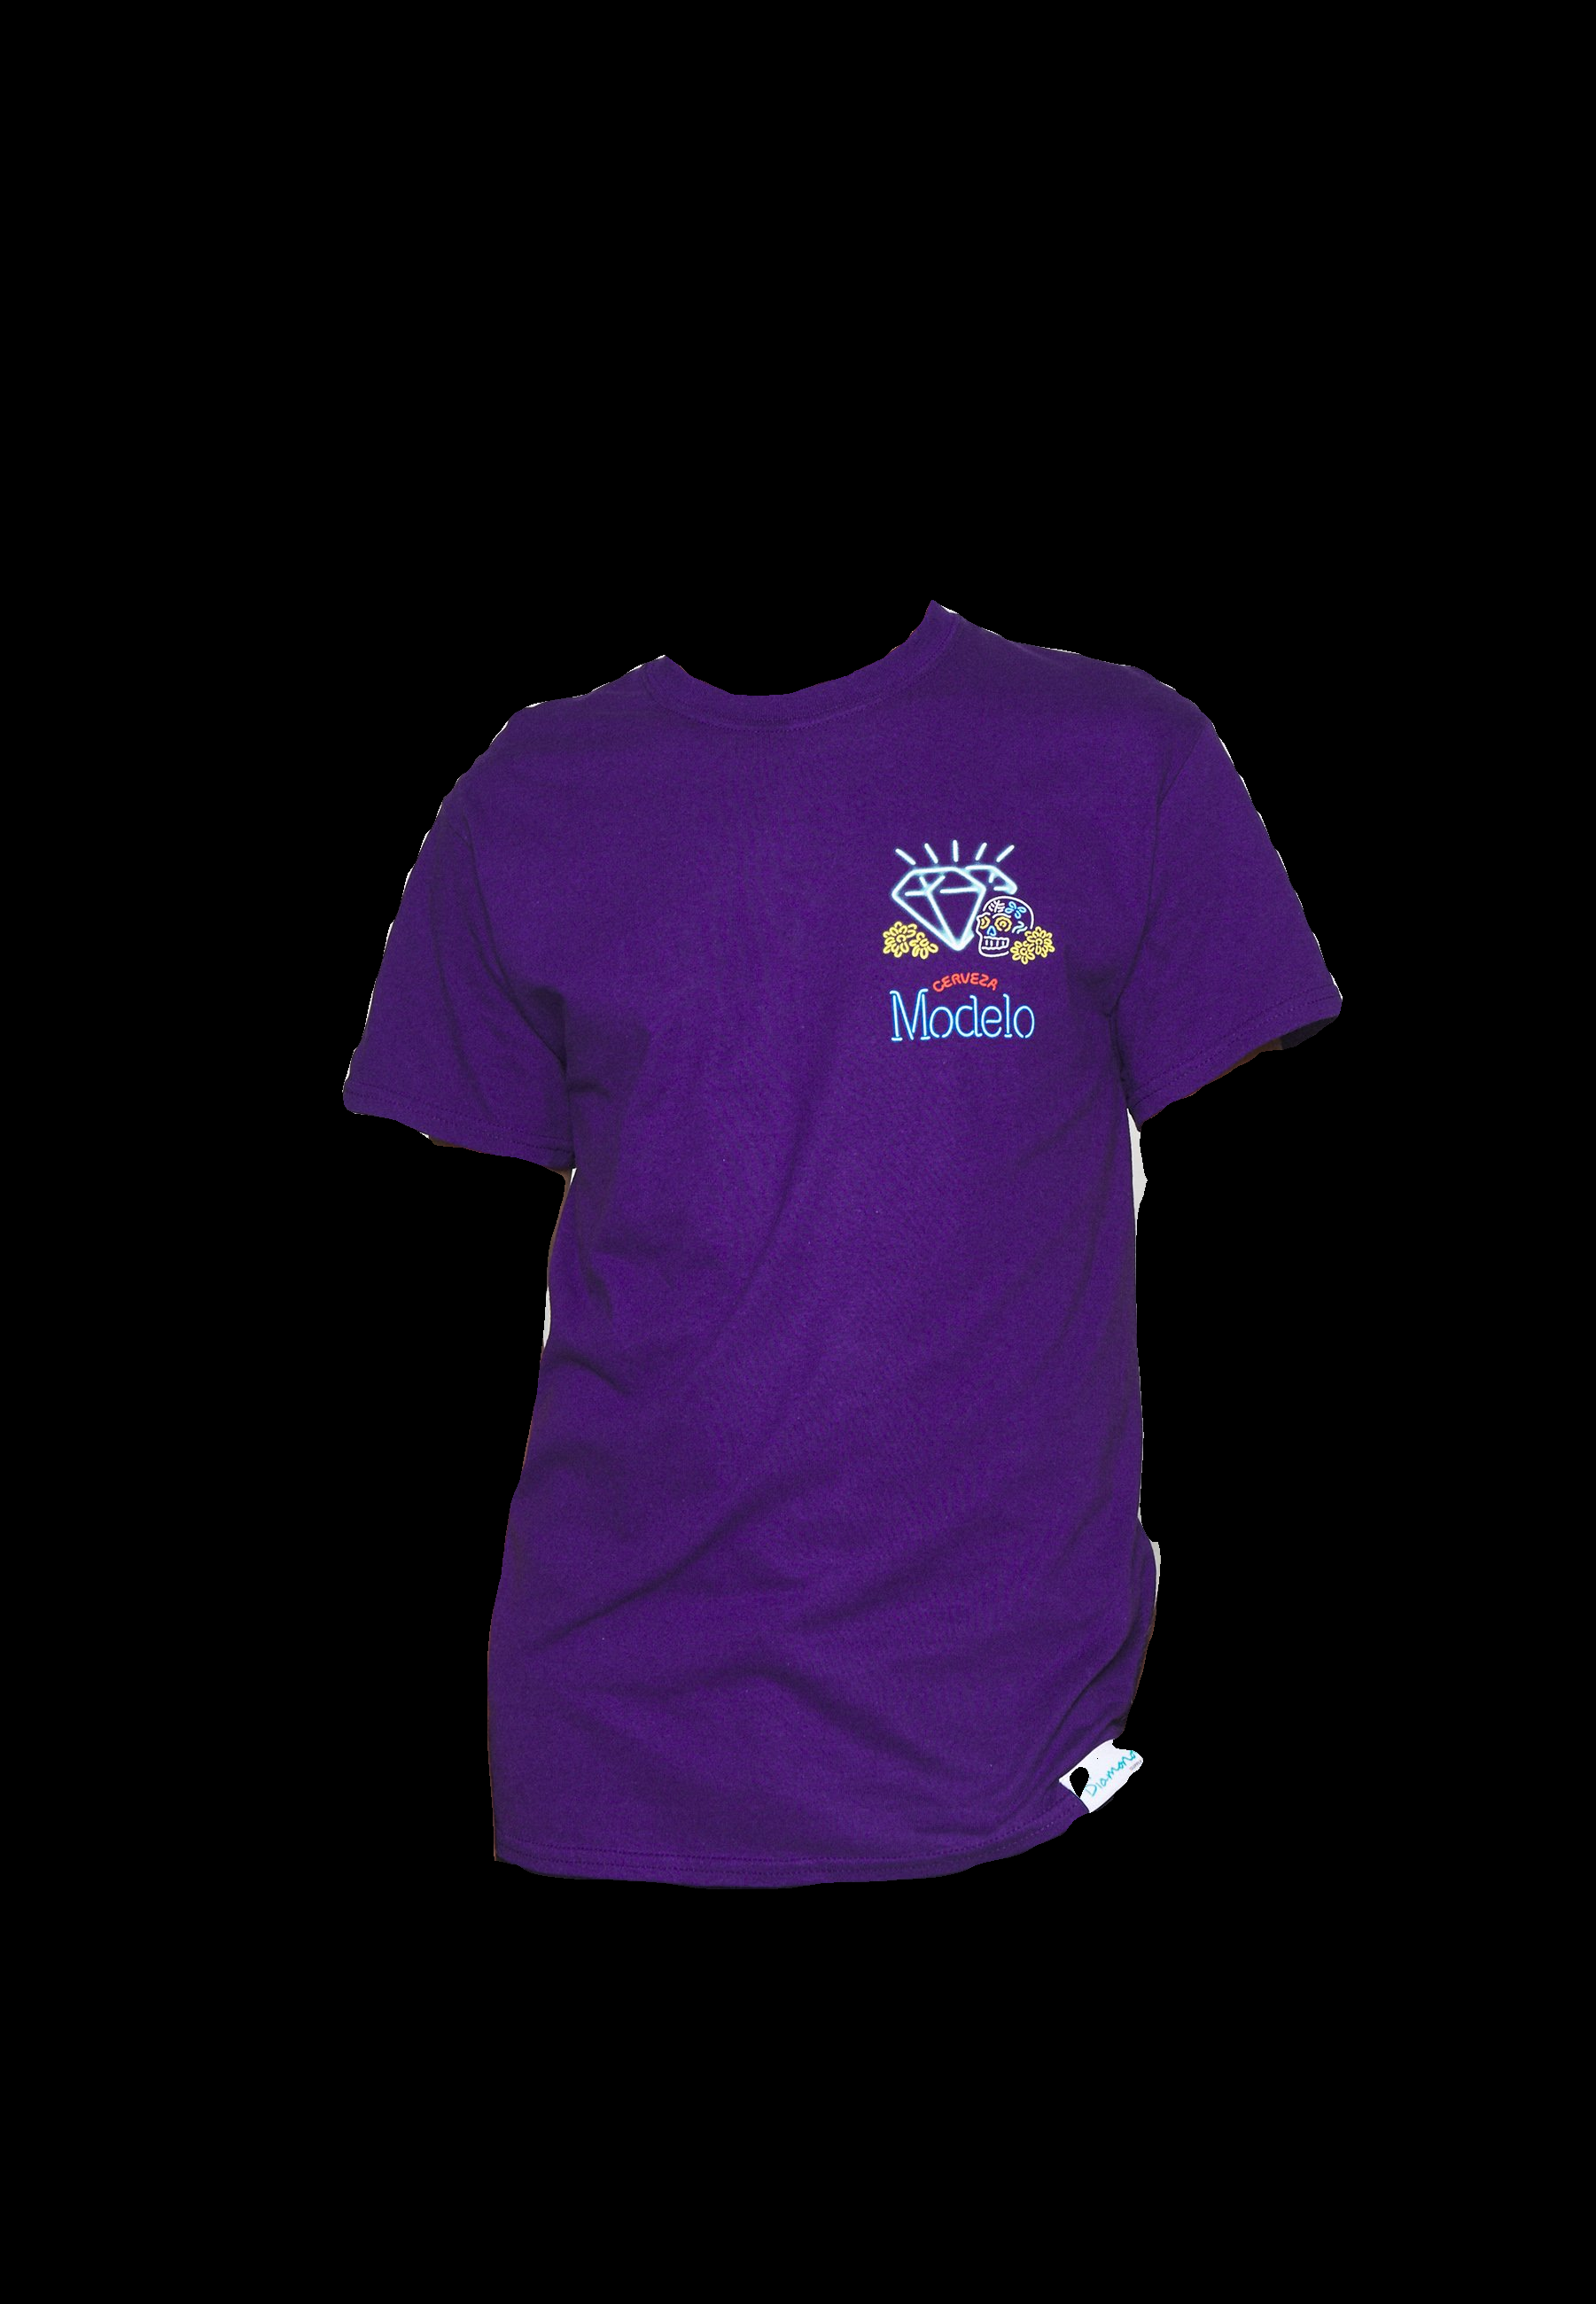

/content/drive/MyDrive
/content/drive/MyDrive/result
extraction results


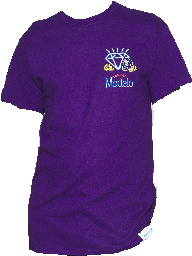

black and white mask


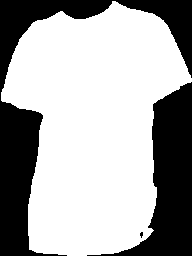

In [9]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

#Used to erase marginal areas outside of clothes
def bounding_rect_img(img):

    img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x, y, w, h = cv2.boundingRect(img_g)
    crop = img[y:y+h, x:x+w]
    return crop

def main():
  #000228 in this case.
  name ='test_image'
  filename = name + '.jpg'
  filename_seg = name + '.png'

  #image_dir : input folder
  image_dir = '/content/drive/MyDrive/input'
  #image_seg : output folder
  image_seg = '/content/drive/MyDrive/output'

  image = cv2.imread(image_dir + '/' + filename)
  image_seg = cv2.imread(image_seg + '/' + filename_seg)

  print("original image")
  cv2_imshow(image)
  print("segmentation results")
  cv2_imshow(image_seg)


  #The blue area is extracted.
  bgrLower = np.array([128, 0, 0])
  bgrUpper = np.array([128, 0, 0])

  #Create mask image
  img_mask = cv2.inRange(image_seg, bgrLower, bgrUpper)
  print("mask image")
  cv2_imshow(img_mask)

  #Composite original image and mask image
  result = cv2.bitwise_and(image, image, mask=img_mask)
  print("composite result")
  cv2_imshow(result)

  #Edit images to fit the virtual try-on format
  crop = bounding_rect_img(result)
  re_crop = cv2.resize(crop, (192,256))
  mask = np.zeros(re_crop.shape[:2], dtype="uint8")
  rect = (1, 1, mask.shape[1], mask.shape[0])
  fgModel = np.zeros((1, 65), dtype="float")
  bgModel = np.zeros((1, 65), dtype="float")
  #Create a black and white mask of the clothes after resizing
  (mask, bgModel, fgModel) = cv2.grabCut(re_crop, mask, rect, bgModel,
                                       fgModel, iterCount=10, mode=cv2.GC_INIT_WITH_RECT)
  outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),0, 1)
  outputMask = (outputMask * 255).astype("uint8")
  re_crop[outputMask==0] = [255, 255, 255]


  %cd /content/drive/MyDrive
  #Create a folder for saving results
  %mkdir result
  %cd result

  cv2.imwrite('model_'+filename,re_crop)
  cv2.imwrite('mask_'+filename,outputMask)

  print("extraction results")
  cv2_imshow(re_crop)
  print("black and white mask")
  cv2_imshow(outputMask)

if __name__ == '__main__':
  main()
